In [2]:
import config
import time

import pandas as pd

from neo4j import GraphDatabase
import matplotlib.pyplot as plt

In [3]:
# set up connection
driver = GraphDatabase.driver(config.uri, auth=(config.user, config.password), encrypted=False)

# Check if connection did work
def check_connectivity(driver):
    try:
        with driver.session() as session:
            result = session.run("RETURN 1 as result")
            record = result.single()
            if record and record["result"] == 1:
                return True
            else:
                print('False')
                return False
    except Exception as e:
        return False


if check_connectivity(driver):
    print("Verbindung erfolgreich hergestellt.")
else:
    print("Fehler bei der Verbindungsherstellung.")

Verbindung erfolgreich hergestellt.


# Graph Database Algorithm

## Projection

In [4]:
def drop_projection() -> None:
    """
    Drop the projection of the graph.
    """
    with driver.session() as session:
        drop_projection_query = "CALL gds.graph.drop('gene_protein_graph')"
        
        session.run(drop_projection_query)
        print("Projection dropped.")

def create_projection() -> None:
    """
    Create a projection of the graph for the gene and protein nodes.
    """
    with driver.session() as session:
        projection_query = """
        CALL gds.graph.project(
            'gene_protein_graph',
            {
                gene: {
                    label: 'gene'
                },
                protein: {
                    label: 'protein'
                }
            },
            {
                INTERACTS: {
                    type: 'INTERACTS',
                    orientation: 'UNDIRECTED'
                },
                CONNECTION: {
                    type: 'CONNECTION',
                    orientation: 'UNDIRECTED'
                }
            }
        )
        """
        
        session.run(projection_query)
        print("Graph projection created.")

# drop_projection()
create_projection()

Graph projection created.


## Helper Functions

In [5]:
def drop_protein_nodes(df) -> pd.DataFrame:
    """
    Drop the protein nodes from the dataframe.
    :param df: The dataframe with the protein nodes.
    """
    return df[~df["node"].str.contains("ENSP")]
    
    

## Pagerank

In [6]:
def run_pagerank() -> pd.DataFrame:
    """
    Pagerank algorithm performed on the genes.
    :return: 
    """
    with driver.session() as session:
        query = """
        CALL gds.pageRank.stream('gene_protein_graph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name ,
               score, 
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY score DESC
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results

start = time.time()

df_pagerank = run_pagerank()

end = time.time()
print(f"Time taken: {round(end - start, 0)} seconds.")


Time taken: 7.0 seconds.


In [7]:
print("Only genes nodes:")
df_pagerank

Only genes nodes:


,node,gene_name,score,delta_tpm,delta_tpm_relevant
0,ENSG00000109339,MAPK10,67.208894,-0.051677,False
1,ENSG00000115392,FANCL,40.200986,0.149585,False
2,ENSG00000107862,GBF1,37.993365,0.034794,False
3,ENSG00000145362,ANK2,36.668287,-0.025229,False
4,ENSG00000121940,CLCC1,34.903938,0.028258,False
...,...,...,...,...,...
134591,ENSG00000231258,ZSWIM5P2,0.150000,0.003669,False
134592,ENSG00000248958,ZSWIM5P3,0.150000,0.000919,False
134593,ENSG00000272589,ZSWIM8-AS1,0.150000,-0.143595,False
134594,ENSG00000232242,ZYG11AP1,0.150000,0.000026,False


In [30]:
print("Only genes with cancer active nodes:")
df_pagerank_relevant = df_pagerank.where(df_pagerank["delta_tpm_relevant"] == True).dropna()

df_pagerank_relevant.head(30)

Only genes with cancer active nodes:


,node,gene_name,score,delta_tpm,delta_tpm_relevant
23,ENSG00000165795,NDRG2,25.635548,-0.317776,True
28,ENSG00000124155,PIGT,24.312624,0.203909,True
33,ENSG00000100749,VRK1,23.428624,0.185753,True
42,ENSG00000154556,SORBS2,22.106196,-0.171024,True
58,ENSG00000161249,DMKN,19.901639,-0.203997,True
76,ENSG00000092529,CAPN3,18.136623,-0.310797,True
113,ENSG00000118513,MYB,15.932185,0.174296,True
122,ENSG00000148053,NTRK2,15.491601,-0.170280,True
148,ENSG00000079215,SLC1A3,14.610763,-0.159338,True
158,ENSG00000157103,SLC6A1,14.170587,-0.267816,True


Text(0.5, 1.0, 'Histogram of Pagerank Scores')

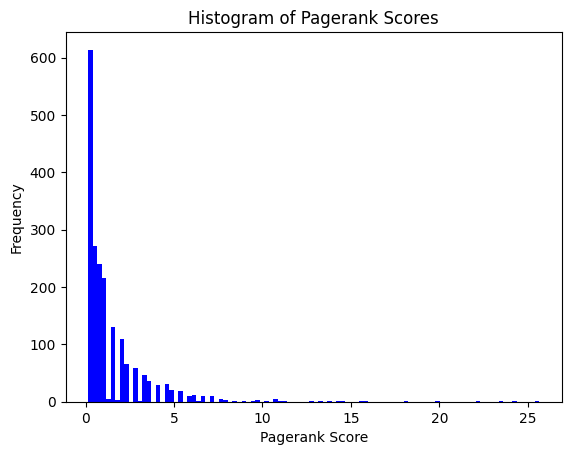

In [31]:
plt.hist(df_pagerank_relevant["score"], bins=100, color='blue')
plt.xlabel("Pagerank Score")
plt.ylabel("Frequency")
plt.title("Histogram of Pagerank Scores")

## Clustering / Community Detection
### Louvain algorithm

In [18]:
def run_louvain() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.louvain.stream('gene_protein_graph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               communityId,
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY communityId
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
df_louvain = run_louvain()

In [19]:
df_louvain

,node,gene_name,communityId,delta_tpm,delta_tpm_relevant
2285,ENSG00000139133,ALG10,4608,0.108206,False
2286,ENSG00000177324,BEND2,4608,-0.015663,False
2287,ENSG00000179088,C12orf42,4608,0.025186,False
2288,ENSG00000177627,C12orf54,4608,-0.121175,False
2289,ENSG00000267221,C17orf113,4608,0.066503,False
...,...,...,...,...,...
134583,ENSG00000174442,ZWILCH,134585,0.189998,True
134588,ENSG00000122952,ZWINT,134586,0.283387,True
134589,ENSG00000232242,ZYG11AP1,134591,0.000026,False
134590,ENSG00000274572,ZYXP1,134593,-0.000010,False


In [27]:
# number of communities
print(f'Number of communities in general: \t\t\t\t{df_louvain["communityId"].nunique()}')

# group by communityId and count the number of cancer active nodes and the total number of nodes
df_louvain_agg = df_louvain.groupby("communityId").agg({"delta_tpm_relevant": "sum", "node": "count"})
# drop communities with a single node
df_louvain_agg = df_louvain_agg.where(df_louvain_agg["node"] > 1).dropna()

print(f'Number of communities with more then 1 node: \t{df_louvain_agg.shape[0]}')

Number of communities in general: 				25347
Number of communities with more then 1 node: 	8


In [29]:
# calculate the ratio of cancer active nodes to the total number of nodes
df_louvain_agg["ratio"] = df_louvain_agg["delta_tpm_relevant"] / df_louvain_agg["node"]

print("Communities with delta tpm relevant nodes:")
df_louvain_agg

Communities with delta tpm relevant nodes:


,delta_tpm_relevant,node,ratio
communityId,,,
4608,18,523.0,0.034417
12319,9,137.0,0.065693
14395,112,1187.0,0.094356
21549,320,1410.0,0.22695
45090,106,1282.0,0.082683
61810,80,992.0,0.080645
69531,122,1914.0,0.063741
70573,3,81.0,0.037037


In [15]:
# TODO And now?

## Similarity
### KNN

In [16]:
def run_knn() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.knn.stream('gene_protein_graph')
        YIELD nodeId, otherNodeId, weight
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               gds.util.asNode(otherNodeId).id AS other_node,
               gds.util.asNode(otherNodeId).gene_name AS other_gene_name,
               weight
        """
    
        result = session.run(query)
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
# df_knn = run_knn()

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown procedure output: `nodeId` (line 3, column 23 (offset: 65))
"        YIELD nodeId, otherNodeId, weight"
               ^}